In [8]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [10]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

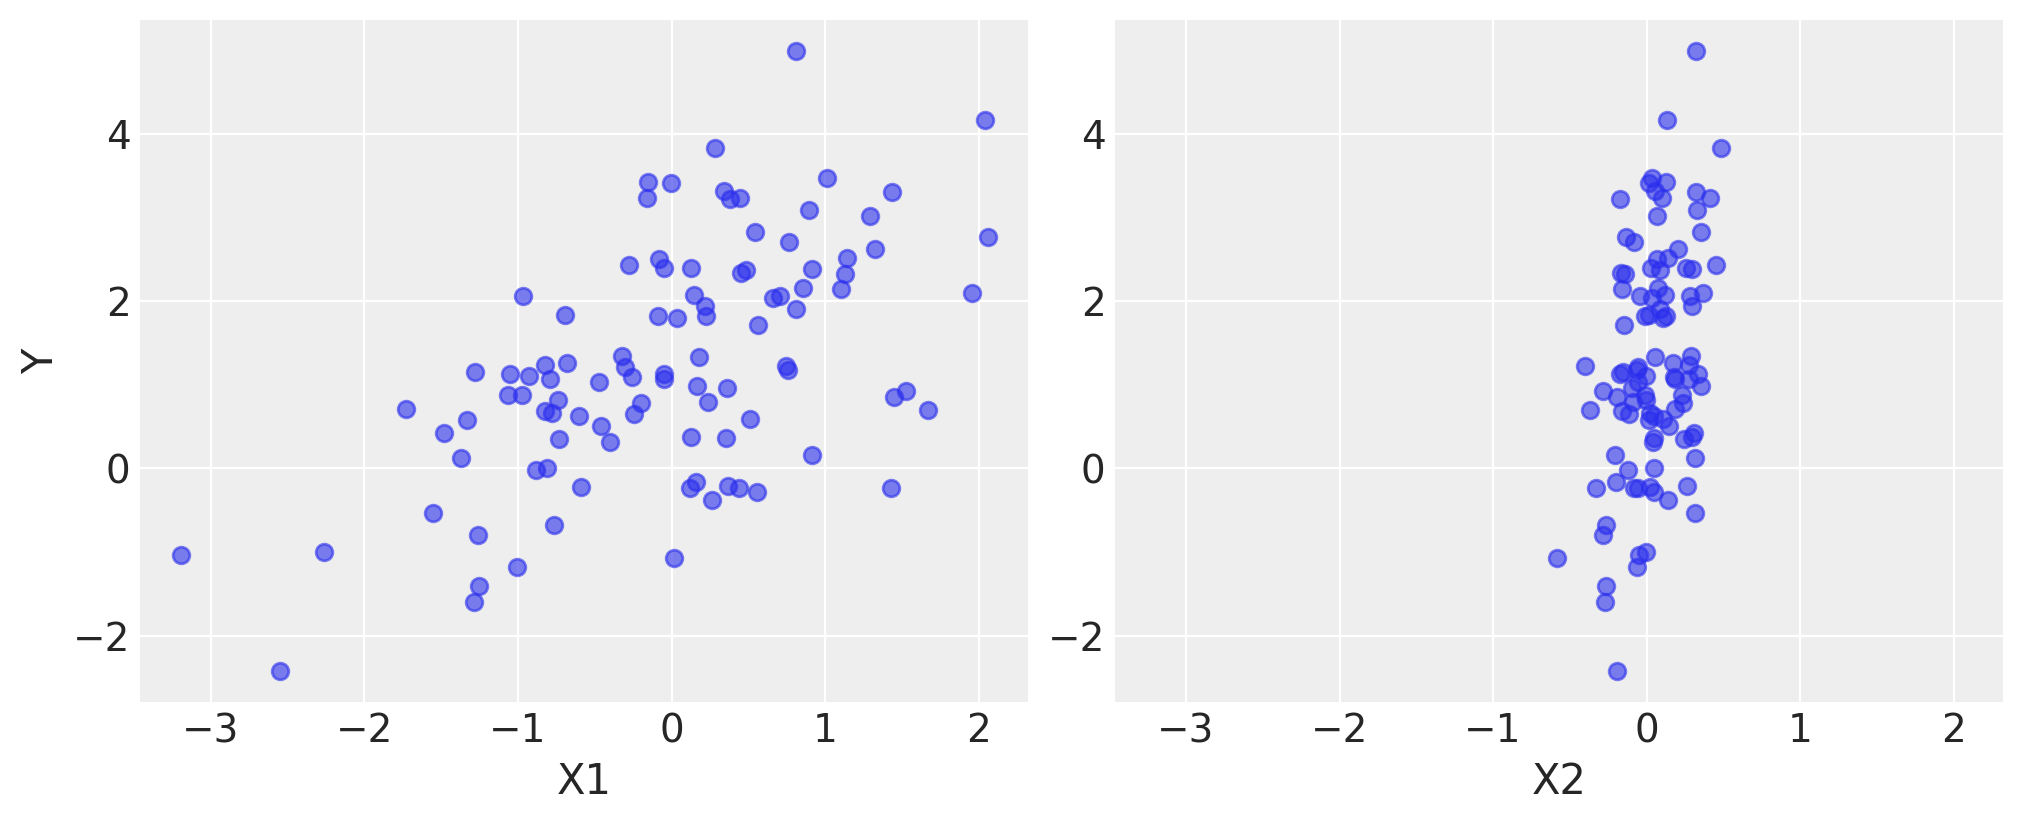

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [12]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.16.2


In [13]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [14]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [15]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [16]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 2, draw: 5)> Size: 80B
array([[1.23455896, 1.05076711, 1.20863248, 1.24982639, 1.04056961],
       [0.98681426, 1.32184226, 1.31053304, 1.16788324, 1.06526785]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 40B 0 1 2 3 4

In [17]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


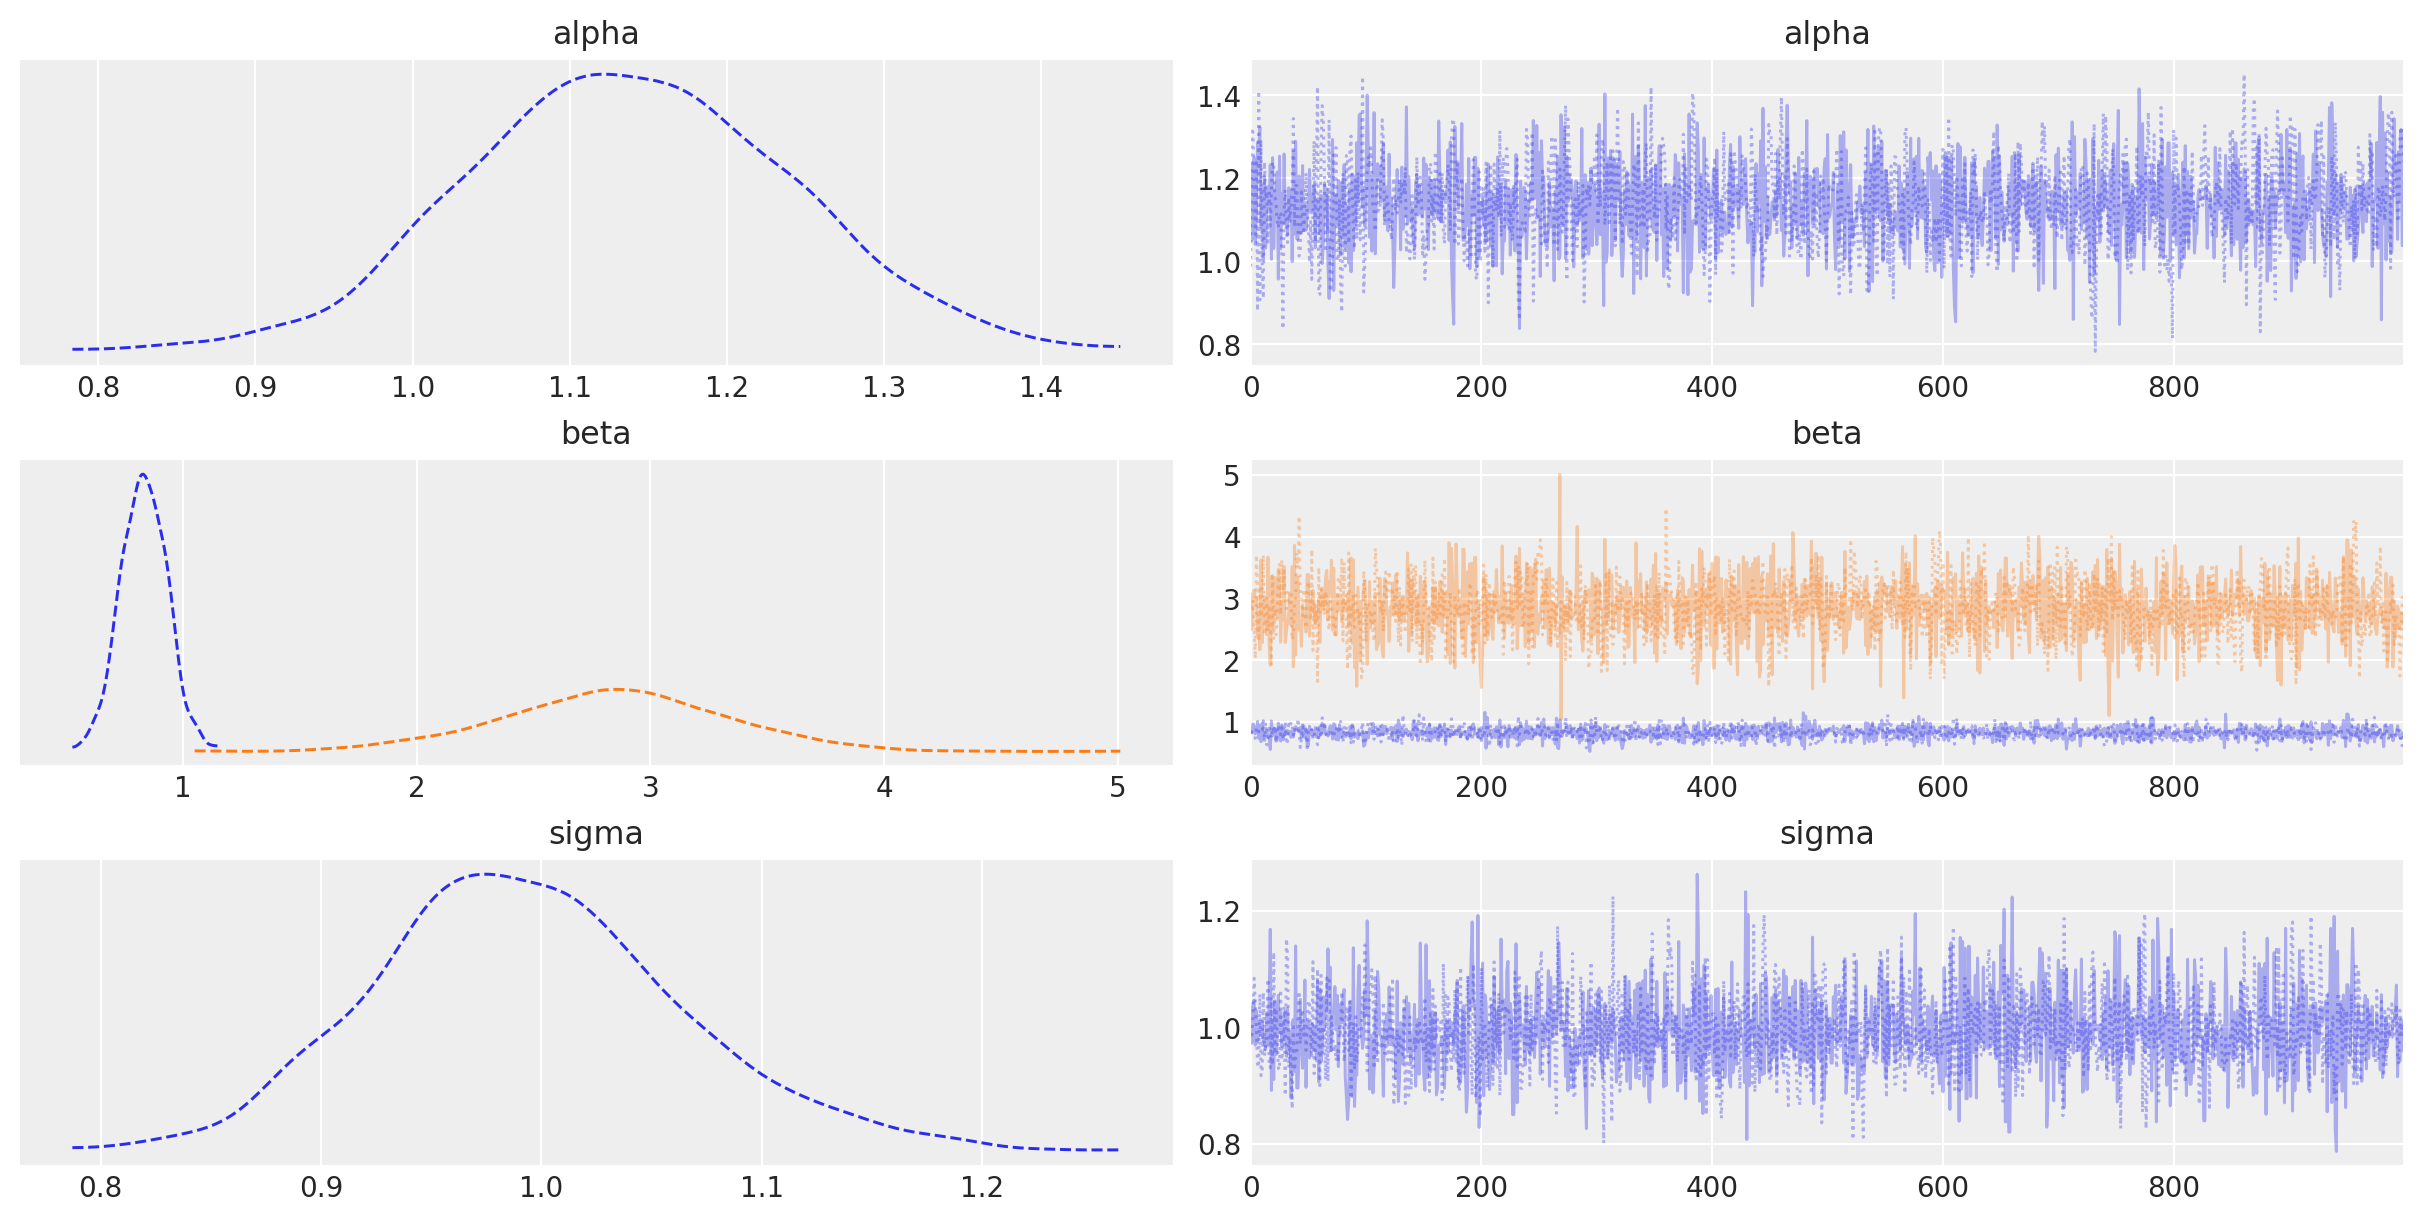

In [19]:
az.plot_trace(idata, combined=True);

In [20]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.14,0.10,0.96,1.33,0.00,0.00,1820.56,1630.60,1.0
beta[0],0.83,0.10,0.63,1.01,0.00,0.00,3216.00,1560.17,1.0
beta[1],2.84,0.48,1.91,3.69,0.01,0.01,2132.12,1554.64,1.0
sigma,0.99,0.07,0.86,1.12,0.00,0.00,2666.46,1323.85,1.0


In [21]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


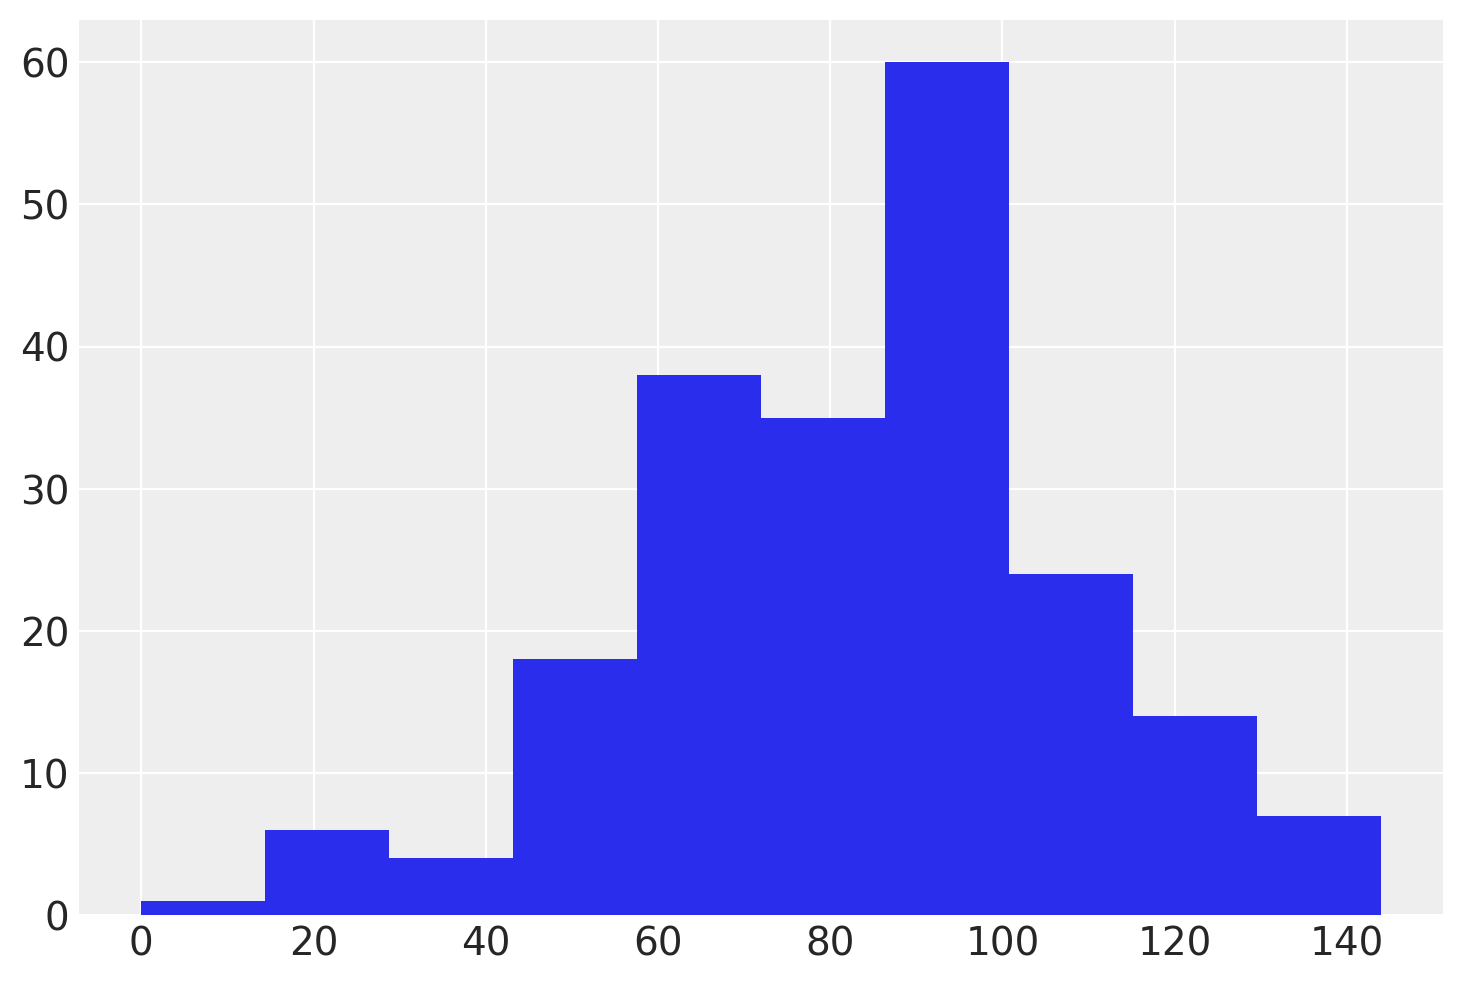

In [22]:
test_scores["score"].hist();

In [23]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

In [25]:
# import pymc3 as pm
# import numpy as np
# import pandas as pd

# Assuming y and n have already been defined in previous code
# y is the full sample, and n is the sample size

# Number of repetitions and chains
Nrep = 10000
Nchains = 3

# PyMC3 model
with pm.Model() as model:

    # Priors
    mu = pm.Normal('mu', mu=3400, sigma=100)
    
    # The gamma distribution in R uses shape and rate; in PyMC3, we use alpha and beta (beta is the inverse of rate)
    shape = (600 ** 2) / (200 ** 2)
    rate = 600 / (200 ** 2)
    sigma = pm.Gamma('sigma', alpha=shape, beta=rate)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    trace = pm.sample(Nrep, chains=Nchains)

# The trace object contains the sampled posterior distributions for mu and sigma
# You can inspect the results using traceplot or summary
#pm.traceplot(trace)
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2943.657,107.373,2733.019,3135.820,0.803,0.568,17893.0,19313.0,1.0
sigma,2530.223,169.197,2220.147,2850.804,1.284,0.908,17322.0,18850.0,1.0


In [26]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
az.plot_trace(trace, combined=True);